In [1]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

JAX version: 0.5.0
jax-cosmo version: 0.1.0


In [2]:
nz_unorm = lambda z : 1.8048 * ( z**0.4170 + z**(0.4170*4.8685) )/(z**4.8685 + 0.7841)

zmin = 0.001
zmax = 4.
nbins = 10 # Number of bins for photometric redshifts

In [3]:
# @title [Run me]

from scipy.integrate import simpson, quad
from scipy.optimize import brentq
from scipy.special import erf

zsamp = jnp.linspace(zmin, zmax,4096)
norm = simpson(nz_unorm(zsamp),zsamp)
nz = lambda z: nz_unorm(z)/norm

def subdivide( nbins, bintype='eq_dens'):
    """ Divide this redshift bins into sub-bins
        nbins : Number of bins to generate
        bintype : 'eq_dens' or 'eq_size'
    """
    # Compute the redshift boundaries for each bin generated
    zbounds = [zmin]
    bins = []
    n_per_bin = 1. / nbins
    for i in range(nbins-1):
        if bintype == 'eq_dens':
                zbound = brentq(lambda z: quad(nz,zmin,z)[0] - (i+1.0)*n_per_bin, zbounds[i], zmax)
        else:
            if bintype != 'eq_size':
                print ('WARNING : unknown binning scheme ' + bintype + '. Assuming equal size bins')
            zbound = (i+1.) * (zmax - zmin)/nbins

        zbounds.append(zbound)
    zbounds.append(zmax)
    return zbounds

photoz_bins = subdivide(10, bintype='eq_dens')

# Photoz distributions for first and last bins
def photz_unorm(z, zmin, zmax, zphot_sig=0.05):
    """ Computes the un-normalized n(z) """
    p = nz(z)

    # Apply photo-z errors
    x = 1.0/(jnp.sqrt(2.0)*zphot_sig*(1.0+z))
    res = 0.5* p *( erf((zmax - z )*x) - erf((zmin - z)*x))
    return res

# Building jax cosmo nz distributions
nzs_s = [jc.redshift.kde_nz(zsamp,
                            photz_unorm(zsamp, zmin=photoz_bins[i], zmax=photoz_bins[i+1]),
                            bw=(zmax - zmin)/4096,
                            gals_per_arcmin2=1./nbins)
           for i in range(0,nbins)]

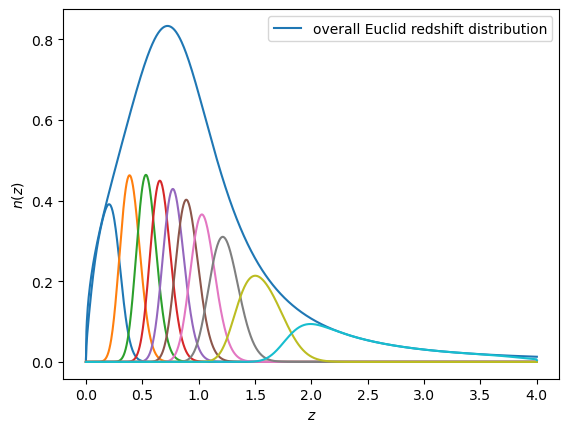

In [5]:
import matplotlib.pyplot as plt
# Plotting the distribution
z = jnp.linspace(0,4,1000);
plt.plot(z, nz(z), label='overall Euclid redshift distribution');

for i in range(nbins):
  plt.plot(z, nzs_s[i](z)*nzs_s[i].gals_per_arcmin2, color='C%d'%i)

plt.legend(loc='best');
plt.xlabel(r'$z$');
plt.ylabel(r'$n(z)$');
# plt.xlim(0,2)

In [6]:
import jax_cosmo.background as bkgrd
from jax_cosmo.scipy.integrate import simps

# Build cosmology object
cosmo = jc.Planck15()

# Defining the function that computes the lensing efficiency kernel

In [7]:
from functools import partial

@jax.jit
@partial(jax.vmap, in_axes=(None, None, 0))
def lensing_efficiency(cosmo, dndz, z):
  chi = bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z))

  def integrand(z_prime):
    chi_prime = bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z_prime))
    return (dndz(z_prime) * jnp.clip(chi_prime - chi, 0) / jnp.clip(chi_prime, 1.0))

  return simps(integrand, z, zmax, 256) * (1.0 + z) * chi

/home/tersenov/anaconda3/envs/jax_new/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Text(0, 0.5, 'n(z) or lensing efficiency')

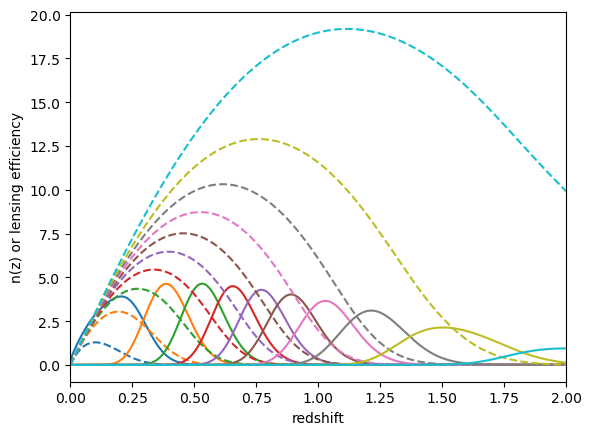

In [8]:
for i in range(nbins):
  plt.plot(z, nzs_s[i](z), color='C%d'%i)
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z)/100, color='C%d'%i, ls='--')

plt.xlim(0,2)
plt.xlabel('redshift')
plt.ylabel('n(z) or lensing efficiency')

In [9]:
# Computing the BNT transform as implemented here: https://github.com/pltaylor16/x-cut/blob/master/BNT.py
import numpy as np

class BNT():

    def __init__(self, z, chi, n_i_list):

        self.z = z
        self.chi = chi
        self.n_i_list = n_i_list
        self.nbins = len(n_i_list)
        
        if np.any(self.chi <= 0):
            raise ValueError("chi must be positive")


    def get_matrix(self):

        A_list = []
        B_list = []
        for i in range(self.nbins):
            nz = self.n_i_list[i]
            A_list += [np.trapz(nz, self.z)]
            B_list += [np.trapz(nz / self.chi, self.z)]

        BNT_matrix = np.eye(self.nbins)
        BNT_matrix[1,0] = -1.

        for i in range(2,self.nbins):
            mat = np.array([ [A_list[i-1], A_list[i-2]], [B_list[i-1], B_list[i-2]] ])
            A = -1. * np.array( [A_list[i], B_list[i]] )
            soln = np.dot(np.linalg.inv(mat), A)
            BNT_matrix[i,i-1] = soln[0]
            BNT_matrix[i,i-2] = soln[1]

        return BNT_matrix

In [10]:
bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z))

Array([   0.      ,   12.205811,   24.314941,   36.32788 ,   48.246094,
         60.071045,   71.80347 ,   83.51343 ,   95.54712 ,  107.48779 ,
        119.336426,  131.09424 ,  142.7622  ,  154.3418  ,  165.87817 ,
        177.75098 ,  189.53442 ,  201.22949 ,  212.83716 ,  224.35889 ,
        235.79468 ,  247.14624 ,  258.80225 ,  270.438   ,  281.98853 ,
        293.45508 ,  304.83838 ,  316.13965 ,  327.35962 ,  338.68213 ,
        350.17822 ,  361.59253 ,  372.92578 ,  384.17896 ,  395.35254 ,
        406.448   ,  417.46558 ,  428.73364 ,  440.0183  ,  451.22485 ,
        462.354   ,  473.4065  ,  484.3833  ,  495.28516 ,  506.11304 ,
        517.24194 ,  528.3274  ,  539.33813 ,  550.27466 ,  561.1384  ,
        571.92944 ,  582.6487  ,  593.2971  ,  604.20874 ,  615.10547 ,
        625.9309  ,  636.68555 ,  647.3699  ,  657.98486 ,  668.53125 ,
        679.0095  ,  689.6316  ,  700.34937 ,  710.99854 ,  721.57983 ,
        732.094   ,  742.54126 ,  752.92285 ,  763.239   ,  773.

In [11]:
z = np.linspace(0.001,4,1000)
bnt = BNT(z, bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z)),
          [nzs_s[i](z) for i in range(nbins)])

M = bnt.get_matrix()

/tmp/ipykernel_3233535/732907347.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  A_list += [np.trapz(nz, self.z)]
/tmp/ipykernel_3233535/732907347.py:24: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B_list += [np.trapz(nz / self.chi, self.z)]


In [12]:
M

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.1312819 , -1.13158983,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.47218334, -1.4721776 ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.63181666, -1.63181974,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.75129003, -1.75129493,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.85926102,
        -1.8592539 ,  1.        ,  0.        

In [13]:
# Looking at the resulting efficiency kernel after BNT transform
eff = np.zeros((10, len(z)))
for j in range(10):
  for i in range(nbins):
    eff[j] += M[j,i]*lensing_efficiency(cosmo, nzs_s[i], z).squeeze()

(0.0, 2.0)

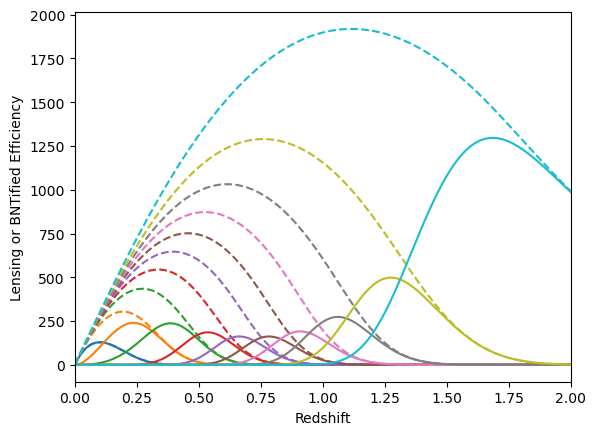

In [14]:
for i in range(nbins):
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z),'--',color='C%d'%i)
  plt.plot(z, eff[i,:],  color='C%d'%i,)

plt.ylabel('Lensing or BNTified Efficiency')
plt.xlabel('Redshift')
plt.xlim(0,2)

# CosmoGRID

In [15]:
import numpy as np

# Load data from a txt file into a NumPy array
nz1 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_1.txt')
nz2 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_2.txt')
nz3 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_3.txt')
nz4 = np.loadtxt('/home/tersenov/CosmoGridV1/stage3_forecast/nz/nz_stage3_4.txt')

In [16]:
nz_unorm = np.zeros((1000, 2))
nz_unorm[:,0] = nz1[:,0]
nz_unorm[:,1] = nz1[:,1] + nz2[:,1] + nz3[:,1] + nz4[:,1]

(0.0, 2.0)

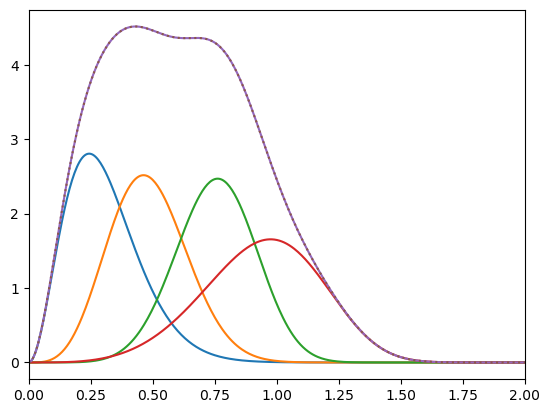

In [17]:
# plot n(z)
plt.plot(nz1[:,0], nz1[:,1])
plt.plot(nz2[:,0], nz2[:,1])
plt.plot(nz3[:,0], nz3[:,1])
plt.plot(nz4[:,0], nz4[:,1])
plt.plot(nz1[:,0], nz1[:,1]+nz2[:,1]+nz3[:,1]+nz4[:,1])
plt.plot(nz_unorm[:,0], nz_unorm[:,1], linestyle=':')
plt.xlim(0,2)

In [18]:
import jax
import jax_cosmo as jc
import jax.numpy as jnp

print("JAX version:", jax.__version__)
print("jax-cosmo version:", jc.__version__)

JAX version: 0.5.0
jax-cosmo version: 0.1.0


In [19]:
nz1_kde = jc.redshift.kde_nz(nz1[:,0], nz1[:,1], bw=0.005)
nz2_kde = jc.redshift.kde_nz(nz2[:,0], nz2[:,1], bw=0.005)
nz3_kde = jc.redshift.kde_nz(nz3[:,0], nz3[:,1], bw=0.005)
nz4_kde = jc.redshift.kde_nz(nz4[:,0], nz4[:,1], bw=0.005)
nz_unorm_kde = jc.redshift.kde_nz(nz_unorm[:,0], nz_unorm[:,1], bw=0.005)

(0.0, 2.0)

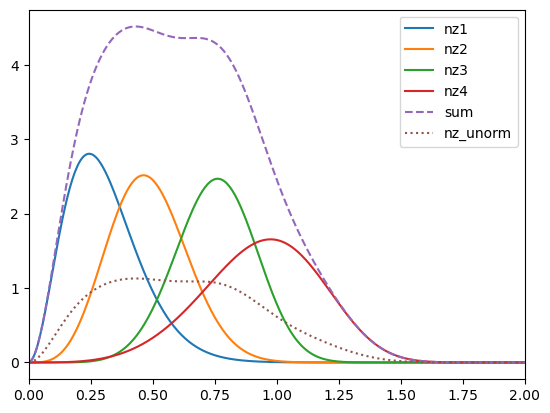

In [20]:
z = np.linspace(0.001,5,1000)
plt.plot(z, nz1_kde(z), label='nz1')
plt.plot(z, nz2_kde(z), label='nz2')
plt.plot(z, nz3_kde(z), label='nz3')
plt.plot(z, nz4_kde(z), label='nz4')
plt.plot(z, nz1_kde(z)+nz2_kde(z)+nz3_kde(z)+nz4_kde(z), linestyle='--', label='sum')
plt.plot(z, nz_unorm_kde(z), linestyle=':', label='nz_unorm')
plt.legend()
plt.xlim(0,2)

In [21]:
zmin = 0.001
zmax = 5.

In [22]:
import jax_cosmo.background as bkgrd
from jax_cosmo.scipy.integrate import simps

# Build cosmology object
cosmo = jc.Planck15()

# Defining the function that computes the lensing efficiency kernel

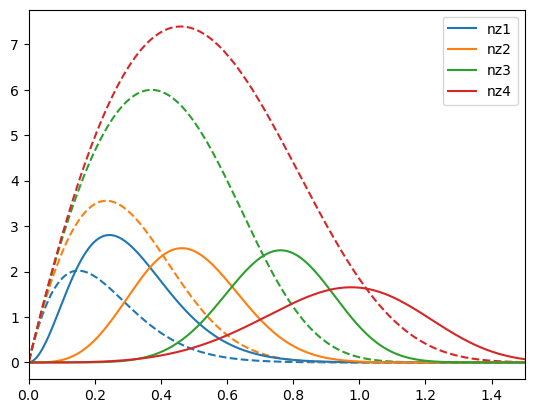

In [23]:
plt.plot(z, lensing_efficiency(cosmo, nz1_kde, z)/100, color='C0', ls='--')
plt.plot(z, lensing_efficiency(cosmo, nz2_kde, z)/100, color='C1', ls='--')
plt.plot(z, lensing_efficiency(cosmo, nz3_kde, z)/100, color='C2', ls='--')
plt.plot(z, lensing_efficiency(cosmo, nz4_kde, z)/100, color='C3', ls='--')

plt.plot(z, nz1_kde(z), label='nz1', color='C0')
plt.plot(z, nz2_kde(z), label='nz2', color='C1')
plt.plot(z, nz3_kde(z), label='nz3', color='C2')
plt.plot(z, nz4_kde(z), label='nz4', color='C3')

plt.xlim(0,1.5)
plt.legend()

In [24]:
z

array([1.00000000e-03, 6.00400400e-03, 1.10080080e-02, 1.60120120e-02,
       2.10160160e-02, 2.60200200e-02, 3.10240240e-02, 3.60280280e-02,
       4.10320320e-02, 4.60360360e-02, 5.10400400e-02, 5.60440440e-02,
       6.10480480e-02, 6.60520521e-02, 7.10560561e-02, 7.60600601e-02,
       8.10640641e-02, 8.60680681e-02, 9.10720721e-02, 9.60760761e-02,
       1.01080080e-01, 1.06084084e-01, 1.11088088e-01, 1.16092092e-01,
       1.21096096e-01, 1.26100100e-01, 1.31104104e-01, 1.36108108e-01,
       1.41112112e-01, 1.46116116e-01, 1.51120120e-01, 1.56124124e-01,
       1.61128128e-01, 1.66132132e-01, 1.71136136e-01, 1.76140140e-01,
       1.81144144e-01, 1.86148148e-01, 1.91152152e-01, 1.96156156e-01,
       2.01160160e-01, 2.06164164e-01, 2.11168168e-01, 2.16172172e-01,
       2.21176176e-01, 2.26180180e-01, 2.31184184e-01, 2.36188188e-01,
       2.41192192e-01, 2.46196196e-01, 2.51200200e-01, 2.56204204e-01,
       2.61208208e-01, 2.66212212e-01, 2.71216216e-01, 2.76220220e-01,
      

In [25]:
bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z))

Array([3.05737305e+00, 1.82663574e+01, 3.33244629e+01, 4.82343750e+01,
       6.29982910e+01, 7.76179199e+01, 9.25263672e+01, 1.07463867e+02,
       1.22258057e+02, 1.36910400e+02, 1.51423340e+02, 1.65842285e+02,
       1.80666748e+02, 1.95352051e+02, 2.09900146e+02, 2.24312988e+02,
       2.38592285e+02, 2.52899902e+02, 2.67482178e+02, 2.81931396e+02,
       2.96249268e+02, 3.10437256e+02, 3.24497803e+02, 3.38612793e+02,
       3.52967773e+02, 3.67195557e+02, 3.81297119e+02, 3.95274658e+02,
       4.09129639e+02, 4.22976318e+02, 4.37117188e+02, 4.51135498e+02,
       4.65032959e+02, 4.78811035e+02, 4.92471436e+02, 5.06015869e+02,
       5.19917480e+02, 5.33737305e+02, 5.47441162e+02, 5.61030273e+02,
       5.74505859e+02, 5.87869873e+02, 6.01355469e+02, 6.14986328e+02,
       6.28505127e+02, 6.41913574e+02, 6.55213135e+02, 6.68405029e+02,
       6.81490723e+02, 6.94865479e+02, 7.08207275e+02, 7.21442627e+02,
       7.34573486e+02, 7.47600342e+02, 7.60524658e+02, 7.73358887e+02,
      

In [26]:
# Computing the BNT transform as implemented here: https://github.com/pltaylor16/x-cut/blob/master/BNT.py
import numpy as np

class BNT():

    def __init__(self, z, chi, n_i_list):

        self.z = z
        self.chi = chi
        self.n_i_list = n_i_list
        self.nbins = len(n_i_list)


    def get_matrix(self):

        A_list = []
        B_list = []
        for i in range(self.nbins):
            nz = self.n_i_list[i]
            A_list += [np.trapezoid(nz, self.z)]
            B_list += [np.trapezoid(nz / self.chi, self.z)]

        BNT_matrix = np.eye(self.nbins)
        BNT_matrix[1,0] = -1.

        for i in range(2,self.nbins):
            mat = np.array([ [A_list[i-1], A_list[i-2]], [B_list[i-1], B_list[i-2]] ])
            A = -1. * np.array( [A_list[i], B_list[i]] )
            soln = np.dot(np.linalg.inv(mat), A)
            BNT_matrix[i,i-1] = soln[0]
            BNT_matrix[i,i-2] = soln[1]

        return BNT_matrix

In [27]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import solve

class BNT:
    def __init__(self, z, chi, n_i_list):
        """
        Initialize the BNT class.

        Parameters:
        z (array): Array of redshift values.
        chi (array): Array of comoving distances corresponding to z.
        n_i_list (list of arrays): List of n_i(z) distributions for each bin.
        """
        self.z = z
        self.chi = chi
        self.n_i_list = n_i_list
        self.nbins = len(n_i_list)
        
        for i, nz in enumerate(self.n_i_list):
            if not jnp.all(jnp.isfinite(nz)):
                raise ValueError(f"Invalid values in nz for bin {i}: {nz}")

        
        if jnp.any(self.chi <= 0):
            raise ValueError("Comoving distance (chi) has zero or negative values, leading to invalid division.")


    def get_matrix(self):
        """
        Compute the BNT matrix.

        Returns:
        jnp.array: The BNT matrix.
        """
        # Precompute A and B lists
        A_list = []
        B_list = []
        for nz in self.n_i_list:
            nz /= jnp.trapezoid(nz, self.z)  # Normalize
            A_list.append(jnp.trapezoid(nz, self.z))         # Trapz integration over z
            B_list.append(jnp.trapezoid(nz / self.chi, self.z))  # Trapz for n_i / chi

        A_list = jnp.array(A_list)
        B_list = jnp.array(B_list)

        # Initialize the BNT matrix
        BNT_matrix = jnp.eye(self.nbins)
        BNT_matrix = BNT_matrix.at[1, 0].set(-1.0)

        # Compute the off-diagonal elements for i >= 2
        for i in range(2, self.nbins):
            mat = jnp.array([[A_list[i-1], A_list[i-2]], [B_list[i-1], B_list[i-2]]])
            A = -jnp.array([A_list[i], B_list[i]])

            # Check for singular matrix
            det_mat = jnp.linalg.det(mat)
            if jnp.isclose(det_mat, 0.0):
                print(f"Skipping bin {i} due to singular matrix. Determinant: {det_mat}")
                continue

            # Solve the linear system mat * soln = A
            soln = solve(mat, A)  # Use JAX's solve for linear systems
            BNT_matrix = BNT_matrix.at[i, i-1].set(soln[0])
            BNT_matrix = BNT_matrix.at[i, i-2].set(soln[1])

        return BNT_matrix


In [28]:
nbins = 4
nzs_s = [nz1_kde, nz2_kde, nz3_kde, nz4_kde]

In [29]:
bnt = BNT(z, bkgrd.radial_comoving_distance(cosmo, jc.utils.z2a(z)),
          [nzs_s[i](z) for i in range(nbins)])

M = bnt.get_matrix()

In [30]:
# Looking at the resulting efficiency kernel after BNT transform
eff = np.zeros((4, len(z)))
for j in range(4):
  for i in range(nbins):
    eff[j] += M[j,i]*lensing_efficiency(cosmo, nzs_s[i], z).squeeze()

In [31]:
M

Array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [-1.        ,  1.        ,  0.        ,  0.        ],
       [ 0.4521097 , -1.4521097 ,  1.        ,  0.        ],
       [ 0.        ,  0.25127807, -1.251278  ,  1.        ]],      dtype=float32)

(0.0, 2.0)

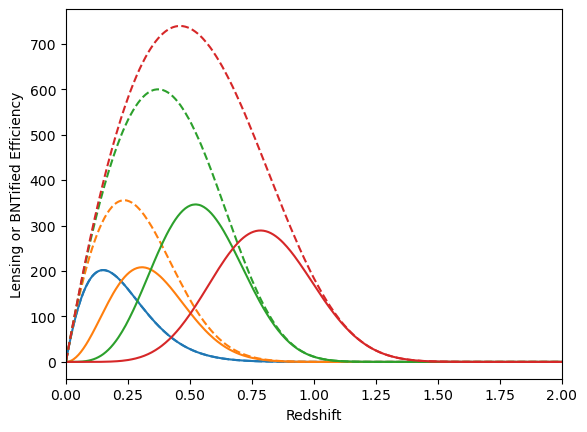

In [32]:
for i in range(nbins):
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z),'--',color='C%d'%i)
  plt.plot(z, eff[i,:],  color='C%d'%i,)

plt.ylabel('Lensing or BNTified Efficiency')
plt.xlabel('Redshift')
plt.xlim(0,2)

In [ ]:
for i in range(nbins):
  plt.plot(z, lensing_efficiency(cosmo, nzs_s[i], z),'--',color='C%d'%i)
  plt.plot(z, eff[i,:],  color='C%d'%i,)

plt.ylabel('Lensing or BNTified Efficiency')
plt.xlabel('Redshift')
plt.xlim(0,2)